# Exploring Topic and Word Relationships

Here we explore different ways that the the newstest 2015 dataset can be looked at.

In [1]:
import math

def read_file(file_path, max_amount=math.inf):
    """
    Reads a number of lines from file and return list of lines
    :param file_path:
    :param max_amount:
    :return: list[str]
    """
    line_list = []

    with open(file=file_path) as f:
        curr_idx = 0
        while curr_idx < max_amount:
            line_list.append(f.readline())
            curr_idx += 1

    return line_list

print("Loading file")
l_raw = read_file('./trg.shuf', 5000000)
print("Finished loading in file")

Loading file
Finished loading in file


In [5]:
def import_vocab(vocab_file_path):
    vocab = []
    with open(file=vocab_file_path) as f:
        curr_idx = 0
        max_amount = 5000000
        lines = f.readlines()
        for line in lines:
            l = line.split()
            if len(l) == 2:
                vocab.append(l[0])
                curr_idx += 1
    return vocab

print("Loading vocab")
target_vocab = import_vocab("./lm.vocab.txt")
print("Loaded vocab. It is of size: " + str(len(target_vocab)))

target_vocab_dic = {}
for w in target_vocab:
    target_vocab_dic[w] = 0


Loading vocab
Loaded vocab. It is of size: 34909


In [ ]:
import math
import pandas as pd
from collections import Counter
import operator
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
from gensim import corpora



def process_word(word, remove_stop=True, lemmatize_and_morph=True):
    """
    Returns process word
    :param word:
    :return: str word
    """
    # lower
    word = word.lower()
    
    # Remove symbols
    if len(word) < 3:
        return None
    
    # Get morph
    if lemmatize_and_morph is True:
        t_word = wn.morphy(word)
        if t_word is not None:
            word = t_word

        # Get lemma
        word = WordNetLemmatizer().lemmatize(word)
    
    # Remove stop
    if remove_stop is True and word in en_stop:
        return None
    return word


def preprocess_all_words(word_list):
    ret = []
    for line in word_list:
        temp = []
        for word in line:
            w = process_word(word, remove_stop=True, lemmatize_and_morph=False)
            if w is not None:
                temp.append(w)
        ret.append(temp)
    return ret


def process_bpe(line_list, seq="@@", rm_words=["\n"], lemmatize_and_morph=True):
    """
    Transforms line list form read_file to list[list[str=words]], and bpe words merged together
    :param line_list:
    :param seq:
    :param rm_words:
    :return: list[list[str=words]]
    """
    full_word_list = []
    for line in line_list:
        temp_words = line.split()
        full_words = []
        idx = 0
        while idx < len(temp_words):
            if temp_words[idx].endswith(seq):
                temp_str = ""
                while temp_words[idx].endswith(seq):
                    temp_str += temp_words[idx][:-(len(seq))]
                    idx += 1
                temp_str += temp_words[idx]
                if temp_str not in rm_words:
                    w = process_word(temp_str, lemmatize_and_morph=lemmatize_and_morph)
                    if w is not None:
                        full_words.append(w)
                idx += 1
            else:
                if temp_words[idx] not in rm_words:
                    w = process_word(temp_words[idx], lemmatize_and_morph=lemmatize_and_morph)
                    if w is not None:
                        full_words.append(w)
                idx += 1
        full_word_list.append(full_words)
    return full_word_list


def process_bpe_to_list(line_list, vocab_dictionary, unk_token="<UNK>"):
    """
    Transforms line list to word list.
    """
    full_word_list = []
    full_word_list_no_UNK = []
    
    for line in line_list:
        temp_words = line.split()
        temp_new_line = []
        temp_new_unk_line = []
        
        for word in temp_words:
            if word in vocab_dictionary:
                temp_new_line.append(word)
                if word not in en_stop and len(word) > 2:
                    temp_new_unk_line.append(word)
            else:
                temp_new_line.append(unk_token)
                
        full_word_list.append(temp_new_line)
        full_word_list_no_UNK.append(temp_new_unk_line)
        
    return full_word_list, full_word_list_no_UNK


def get_word_count(word_list):
    """
    Returns word count.
    :param word_list:
    :return: List[(str=word, int=count)]
    """
    word_count = {}
    for line in word_list:
        for word in line:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    return sorted(word_count.items(), key=operator.itemgetter(1))


def get_topics_lda(word_list, dictionary, num_topics=10):
    corpus = [dictionary.doc2bow(text) for text in word_list]
    print("Finished corpus")
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=4)
    print("Topics: ")
    for topic in topics:
        print(topic)

    return topics, ldamodel, corpus, dictionary


num_topics = 5

import random
l = random.sample(l_raw, 50000)

print("Started training step")

#wl = process_bpe(line_list=l)
wl, wl_clean = process_bpe_to_list(line_list=l, vocab_dictionary=target_vocab_dic, unk_token="<UNK>")
print("Vocab size train: " + str(len(get_word_count(word_list=wl))))

#wl_full = process_bpe(line_list=l_raw, lemmatize_and_morph=False)
wl_full, wl_full_clean = process_bpe_to_list(line_list=l_raw, vocab_dictionary=target_vocab_dic, unk_token="<UNK>")
print("Vocab size full: " + str(len(get_word_count(word_list=wl_full))))

dictionary = corpora.Dictionary(wl_full)
print("Finished Dictionary")

t, ldamodel,_, dictionary = get_topics_lda(word_list=wl_clean, dictionary=dictionary, num_topics=num_topics)




[nltk_data] Downloading package wordnet to /home/nikita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Started training step
Vocab size train: 26816





# Visualization
Here we visualize with pyLDAvis in an interactive mode the LDA analysis.

In [8]:
import pyLDAvis.gensim
from gensim import corpora
dictionary = corpora.Dictionary(wl)
corpus = [dictionary.doc2bow(text) for text in wl]
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

# Vocab Splitting

Here we get the vocab for each topic.

In [9]:
def get_representatives_lda(word_list, lda_model, dictionary, num_topics=10):
    max_line = [[]] * num_topics
    max_class = [0] * num_topics 
    class_vocab = {i:{} for i in range(0, num_topics)}
    
    for line, idx in zip(word_list, range(len(word_list))):
        #print(line)
        new_doc_bow = dictionary.doc2bow(line)
        s = ldamodel.get_document_topics(new_doc_bow)
        s.sort(key=lambda x: x[1])
        t_max_class, t_max_perc = s[-1]
        
        for word in line:
            if word in class_vocab[t_max_class]:
                class_vocab[t_max_class][word] += 1
            else:
                class_vocab[t_max_class][word] = 1
        
        if max_class[t_max_class] < t_max_perc:
            max_class[t_max_class] = t_max_perc
            max_line[t_max_class] = line
        
        if idx % 100000 == 0:
            print("Representatives: " + str(idx))
        
    print("Finished representatives")
    return max_line, max_class, class_vocabprint("Here")


_, _, class_vocab = get_representatives_lda(wl_full, ldamodel, dictionary, num_topics=num_topics)

Representatives: 0
Representatives: 100000
Representatives: 200000
Representatives: 300000
Representatives: 400000
Representatives: 500000
Representatives: 600000
Representatives: 700000
Representatives: 800000
Representatives: 900000
Representatives: 1000000
Representatives: 1100000
Representatives: 1200000
Representatives: 1300000
Representatives: 1400000
Representatives: 1500000
Representatives: 1600000
Representatives: 1700000
Representatives: 1800000
Representatives: 1900000
Representatives: 2000000
Representatives: 2100000
Representatives: 2200000
Representatives: 2300000
Representatives: 2400000
Representatives: 2500000
Representatives: 2600000
Representatives: 2700000
Representatives: 2800000
Representatives: 2900000
Representatives: 3000000
Representatives: 3100000
Representatives: 3200000
Representatives: 3300000
Representatives: 3400000
Representatives: 3500000
Representatives: 3600000
Representatives: 3700000
Representatives: 3800000
Representatives: 3900000
Representatives

In [10]:


# max_l, max_c, class_vocab = get_representatives_lda(wl, ldamodel, dictionary)
"""
for idx in range(len(max_l)):
    print("\n")
    print("\n")
    print(max_c[idx])
    print(max_l[idx])
"""  

# get overlap
#num_topics = 20

import numpy as np


def get_overlap_matrix(class_vocab, num_topics):
    over_lap_matrix = np.zeros((num_topics, num_topics))
    over_lap_vocab = {}
    
    for c in range(0, num_topics):
        for c2 in range(0, num_topics):
            # Skip self
            if c2 >= c:
                continue
            # overlap
            words_in_c2_and_c1 = 0
            total_words_c2 = 0
            
            for word in class_vocab[c2]:
                if word not in over_lap_vocab:
                    over_lap_vocab[word] = np.zeros((num_topics, num_topics))
                
                total_words_c2 += 1 
                if word in class_vocab[c]:
                    words_in_c2_and_c1 += 1
                    over_lap_vocab[word][c, c2] = 1
            # Normalize        
            c_factor = len(class_vocab[c])/(len(class_vocab[c2]) + len(class_vocab[c]))
            c2_factor = len(class_vocab[c2])/(len(class_vocab[c2]) + len(class_vocab[c]))
            over_lap_matrix[c, c2] = (words_in_c2_and_c1/len(class_vocab[c2])) * c2_factor + (words_in_c2_and_c1/len(class_vocab[c])) * c_factor
    
    return over_lap_matrix, over_lap_vocab


over_lap_matrix, over_lap_vocab = get_overlap_matrix(class_vocab, num_topics)

over_lap_sum = 0
over_lap_count = 0
for c in range(0, num_topics):
    for c2 in range(0, num_topics):
        # Skip self
        if c2 >= c:
            continue
        over_lap_sum += over_lap_matrix[c, c2]
        over_lap_count += 1
        
over_lap_avg = over_lap_sum/over_lap_count

print("Overlap Matrix of Vocab")
print(pd.DataFrame(over_lap_matrix))
print("\n")

print("Average overall")
print(over_lap_avg)

print("\n")
print("Max")
print(np.max(over_lap_matrix))
      

Overlap Matrix of Vocab
          0         1         2         3    4
0  0.000000  0.000000  0.000000  0.000000  0.0
1  0.677910  0.000000  0.000000  0.000000  0.0
2  0.976904  0.665747  0.000000  0.000000  0.0
3  0.969546  0.657737  0.973447  0.000000  0.0
4  0.982165  0.673222  0.979821  0.973484  0.0


Average overall
0.8529982624888062


Max
0.9821653100390444


# Results



## LDA

### 20 Topics, 50000 clustering, 5 million testing:

Without stop words, after pbe processing, overall average 32.8% (max 42.5%).

### 5 Topics, 50000 clustering, 5 million testing:


Without stop words, after pbe processing, overall average 21.4% (max 29.7%).


### TODO: 10 Topics, full bpe vocab

# Exploring vocab overlap

In [11]:
vocab_overlap_list = [(word, np.sum(over_lap_vocab[word])) for word in over_lap_vocab]
sort_vocab_overlap = sorted(vocab_overlap_list, key=lambda tup: tup[1])

print("Top 100 overlapping words: ")
print(sort_vocab_overlap[-100:-1])




Top 100 overlapping words: 
[('Template', 10.0), ('ло@@', 10.0), ('й@@', 10.0), ('о', 10.0), ('ф@@', 10.0), ('ны@@', 10.0), ('со@@', 10.0), ('во@@', 10.0), ('Cré@@', 10.0), ('Episode', 10.0), ('continu@@', 10.0), ('ви@@', 10.0), ('де@@', 10.0), ('ihr', 10.0), ('ы', 10.0), ('ware-@@', 10.0), ('unspoilt', 10.0), ('Ρ@@', 10.0), ('Luz', 10.0), ('Mobili@@', 10.0), ('Workshops', 10.0), ('Metropole', 10.0), ('brow@@', 10.0), ('puy', 10.0), ('arios', 10.0), ('stadt@@', 10.0), ('konnten', 10.0), ('enheit', 10.0), ('Celsius', 10.0), ('spati@@', 10.0), ('Λ@@', 10.0), ('wör@@', 10.0), ('sen-@@', 10.0), ('Abru@@', 10.0), ('má@@', 10.0), ('Micro', 10.0), ('Liefer@@', 10.0), ('Danuta', 10.0), ('machen', 10.0), ('POLIC@@', 10.0), ('Plen@@', 10.0), ('Himm@@', 10.0), ('konnte', 10.0), ('bels', 10.0), ('CONCLUSIONS', 10.0), ('Sprach@@', 10.0), ('Ο', 10.0), ('Human@@', 10.0), ('Firmware', 10.0), ('AUT@@', 10.0), ('TEI@@', 10.0), ('configur@@', 10.0), ('NORDENIA', 10.0), ('Barcelon@@', 10.0), ('atz', 10.0)

dict_items([(0.0, 722073), (1.0, 103973), (3.0, 39650), (6.0, 20821), (10.0, 16423)])
902940


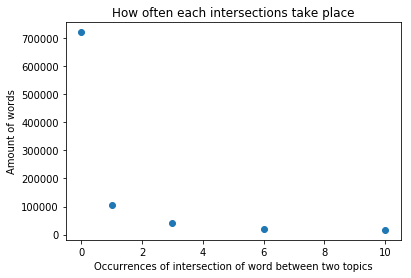

In [6]:
over_lap_distribution = {}
for word, count in sort_vocab_overlap:
    if count in over_lap_distribution:
        over_lap_distribution[count] += 1
    else:
        over_lap_distribution[count] = 1

over_lap_distribution = over_lap_distribution.items()
print(over_lap_distribution)
print(sum([v[1] for v in over_lap_distribution]))

%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*zip(*over_lap_distribution))
plt.title("How often each intersections take place")
plt.xlabel("Occurrences of intersection of word between two topics")
plt.ylabel("Amount of words")
plt.show()

In [23]:
def find_context(word_str):
    for line in wl_full:
        for word in line:
            if word == word_str:
                print(" ")
                print(line)
                new_doc_bow = dictionary.doc2bow(line)
                s = ldamodel.get_document_topics(new_doc_bow)
                s.sort(key=lambda x: x[1])
                t_max_class, t_max_perc = s[-1]
                print("Attributed to topic: " + str(t_max_class) + " with percentage: " + str(t_max_perc))

find_context("cool")


 
['cool', '...']
Attributed to topic: 0 with percentage: 0.726176
 
['campino', 'always', 'popular', 'sweet', 'lovers', 'adore', 'unique', 'fruity', 'taste', 'experience', 'sunny', 'flavour', 'sweet', 'fruit', 'fresh', 'cool', 'creamy', 'yoghurt', 'rounded', 'subtle', 'flower', 'essences', 'makes', 'campino', 'refreshing', 'summery']
Attributed to topic: 4 with percentage: 0.56952053
 
['leave', 'cool', 'briefly', 'let', 'chocolate', 'get', 'hard']
Attributed to topic: 4 with percentage: 0.5343439
 
['posts', 'really', 'cool', 'think', 'first', 'suggest', 'already', 'april']
Attributed to topic: 2 with percentage: 0.8964645
 
['rooms', 'pool', 'never', 'crowded', 'absence', 'groups', 'silence', 'countryside', 'allow', 'live', 'unforgettable', 'moments', 'peace', 'read', 'listen', 'music', 'surfing', 'online', 'laptop', 'sip', 'cool', 'glass', 'wine', 'perhaps', 'romantic', 'dinner', 'frame', 'decline', 'cilento', 'hills', 'case', 'return', 'home', 'daily', 'life', 'city', 'rested', 'u

Attributed to topic: 2 with percentage: 0.5289884
 
['upton', 'romantically', 'linked', 'professional', 'dancer', 'maksim', 'chmerkovskiy', 'tells', 'cbsnews.com', "'re", 'cool', 'says']
Attributed to topic: 2 with percentage: 0.86229444
 
['take', 'oven', 'leave', 'cool']
Attributed to topic: 0 with percentage: 0.5349451
 
['feel', 'like', 'fred', 'macmurray', 'shaka', 'brilliant', 'smart', 'cool', 'fighter', 'calhoun', 'said']
Attributed to topic: 0 with percentage: 0.50960505
 
['calm', 'atmosphere', 'patio', 'enhanced', 'scent', 'fragrant', 'shrubs', 'cool', 'air', 'fountain']
Attributed to topic: 2 with percentage: 0.6232683
 
['handle', 'cool', 'dvd', 'player', 'different', 'languages', 'surprised', 'uses', 'player']
Attributed to topic: 4 with percentage: 0.88280153
 
['though', 'related', 'core', 'personal', 'section', 'someone', 'thinking', 'would', 'cool', 'misinterpret', 'statement', 'therein', 'try', 'hurt']
Attributed to topic: 2 with percentage: 0.6250356
 
['cool', 'knea

 
['also', 'accent', 'seems', 'alternate', 'american', 'british', 'french', 'cool']
Attributed to topic: 4 with percentage: 0.5350758
 
['end', 'cold', 'cool', 'week', 'vans', 'penken', 'park', 'opening', 'week', 'must', 'many', 'pros', 'djs', 'party', 'people', 'snowboard', 'enthusiasts']
Attributed to topic: 2 with percentage: 0.64842373
 
['keep', 'cool', 'trail', 'even', 'gets', 'rough']
Attributed to topic: 0 with percentage: 0.61742306
 
['yeeeeeeeesssssssss', 'axel', 'actually', 'cool', 'competition', 'pilot', 'tried', 'hide', 'excitement', 'stupidity', 'asking', 'almost', 'intelligent', 'questions', 'design', 'performance', 'projections', 'timescales', 'logistics', 'arrangements', 'blah', 'blah', 'remember', 'much', 'phone', 'call', 'clear', 'project', 'involving', 'lot', 'people', 'real', 'team', 'effort', 'lot', 'responsibility', 'everyone', 'work', 'hard', 'deliver']
Attributed to topic: 2 with percentage: 0.5900832
 
['first', 'person', 'described', 'note', 'card', 'thought

Attributed to topic: 1 with percentage: 0.35274208
 
['handling', 'early', 'dramas', 'coalition', 'formed', 'cemented', 'reputation', 'cool', 'head']
Attributed to topic: 2 with percentage: 0.8808043
 
['cool', 'modern', 'café', 'middle', 'city']
Attributed to topic: 1 with percentage: 0.6127599
 
['cool', 'bright', 'star', 'eternal', 'laughter']
Attributed to topic: 2 with percentage: 0.8622909
 
['malt', 'stored', 'clean', 'cool', 'dry', 'area', 'conditions', 'observed', 'recommend', 'use', 'whole', 'kernel', 'products', 'within', 'months', 'date', 'manufacture', 'milled', 'products', 'within', 'months']
Attributed to topic: 2 with percentage: 0.586232
 
['average', 'minimum', 'temperatures', 'time', 'around', '60ºf', '15ºc', 'rarely', 'dipping', '40ºf', '4ºc', 'equivalent', 'maxima', 'usually', 'range', '21-27', 'dry', 'cool', 'season', 'gulf', 'stream', 'helps', 'moderate', 'effect', 'cold', 'front', 'often', 'bring', 'freezing', 'temperatures', 'northerly', 'portions', 'florida']


 
['cool', 'eat', 'kale']
Attributed to topic: 2 with percentage: 0.72057486
 
['people', 'party', 'style', 'cool', 'elegance', 'hotel', 'evident', 'everywhere']
Attributed to topic: 2 with percentage: 0.43518788
 
['gulf', 'dianese', 'known', 'mild', 'winters', 'cool', 'summers']
Attributed to topic: 0 with percentage: 0.7926771
 
['curious', 'spanish', 'version', 'ease', 'ease', '...', 'smoothing', 'spline', 'curves', 'movement', '...', 'confused', 'word', 'easy', 'rather', 'ease', 'would', 'relaxed', 'loose', 'soft', '...', 'cool', 'appropriate']
Attributed to topic: 1 with percentage: 0.32663834
 
['catch', 'many', 'frogs', 'win', 'high-end', 'runes', 'magic', 'branded', 'ultraforce', 'msi', '725', 'gaming', 'notebook', 'cool', 'roccat', 'gaming', 'peripherals']
Attributed to topic: 1 with percentage: 0.5359721
 
['finally', 'gave', 'cool', 'part']
Attributed to topic: 1 with percentage: 0.7939594
 
['hurried', 'clinic', 'cool', 'night', 'breeze', 'blew', 'tongolo', 'valleys', 'sea

 
['spent', 'lot', 'hours', 'work', 'front', 'composition', 'drums', 'patterns', 'trying', 'imitate', 'alfred', 'style', 'obtained', 'excellent', 'result', 'programming', 'sounds', 'cool', 'real']
Attributed to topic: 2 with percentage: 0.6866602
 
['big', 'leap', 'standards', 'small', 'step', 'price', 'yeah', 'cheesy', 'place', 'cool']
Attributed to topic: 4 with percentage: 0.6382972
 
['food', 'beverage', 'rooftop', 'cool', 'bar', 'area', 'snacks', 'available', 'day', 'night', 'breakfast', 'served', 'late', 'guests', 'sign', 'dinner']
Attributed to topic: 2 with percentage: 0.59216136
 
['really', 'cool', 'guys', 'nice', 'ones']
Attributed to topic: 2 with percentage: 0.44933373
 
['customers', 'worldwide', 'showing', 'interest', 'instance', 'multifunctional', 'jackets', 'communicate', 'cool', 'illuminate', 'measure', 'protect', 'warm', 'time', 'says', 'michael', 'jänecke']
Attributed to topic: 2 with percentage: 0.56303215
 
['fiery', 'sunsets', 'summer', 'enjoyed', 'cool', 'pool',

 
['steam', 'bath', 'hammam', 'maierl-alm', 'standing', 'spa', 'area', 'main', 'house', 'room', 'temperature', 'body', 'comes', 'rest', 'active', 'day', 'mountains', 'kitzbühel', 'kirchberg', 'tyrol', 'austria', 'steam', 'bath', 'guests', 'cool', 'adjacent', 'shower', 'fresh', 'spring', 'water', 'natural', 'spring']
Attributed to topic: 3 with percentage: 0.4582945
 
['room', 'cool', 'moist', 'warm', 'dry', 'speed', 'evaporation', 'zyklon', 'floor', 'walls', 'ceiling', 'rough', 'masonry', 'poison', 'gas', 'easily', 'absorbed', 'porous', 'surfaces', 'means', 'would', 'impossible', 'clean', 'room', 'thoroughly', 'masonry', 'would', 'release', 'cyanide', 'gas', 'times', 'endangering', 'anyone', 'entered', 'room']
Attributed to topic: 2 with percentage: 0.5765581
 
['think', 'drawing', 'attention', 'get', 'prepared', 'explain', 'cool', 'library', 'extremely', 'useful', 'developer', 'tool', 'also', 'system', 'completely', 'different', 'everything', 'else', 'developers', 'got', 'used', 'use'

 
['daniel', 'kid', 'loved', 'mtv', 'fresh', 'played', 'music', 'videos', 'time', 'thought', 'really', 'cool']
Attributed to topic: 2 with percentage: 0.50109303
 
['winter', 'keep', 'temperature', 'lower', 'degrees', 'celsius', 'keep', 'south', 'window', 'warm', 'enough', 'water', 'properly', 'fall', 'winter', 'rest', 'instead', 'grow', 'bloom', 'winter', 'fill', 'room', 'fragrance', 'room', 'cool', 'keep', 'dry', 'leaves', 'fall', 'dormant', 'winter']
Attributed to topic: 2 with percentage: 0.6398185
 
['set', 'right', 'beach', 'beside', 'golf', 'course', 'hotel', 'different', 'accommodation', 'stunning', 'views', 'private', 'balconies', 'cool', 'outdoor', 'pool', 'workout', 'gym']
Attributed to topic: 2 with percentage: 0.54715216
 
['look', 'cool', 'shaded', 'spot', 'rest', 'stop', 'energy', 'sapping', 'activities']
Attributed to topic: 0 with percentage: 0.6741052
 
['pumped', 'get', 'top', 'five', 'gnarly', 'race', 'said', 'shows', 'putting', 'work', 'off-season', 'cool', 'see', 

Attributed to topic: 2 with percentage: 0.70752734
 
['keep', 'plants', 'shade', 'cool', 'spot', 'couple', 'days', 'important']
Attributed to topic: 2 with percentage: 0.8808445
 
['store', 'cool', 'dry', 'place', 'away', 'light', 'heat']
Attributed to topic: 1 with percentage: 0.55380815
 
['politicians', 'must', 'acutely', 'aware', 'try', 'keep', 'cool', 'head', 'times']
Attributed to topic: 2 with percentage: 0.8965149
 
['dance', 'wild', 'spontaneous', 'frenzied', 'kicks', 'body', 'movements', 'cool', 'sophisticated']
Attributed to topic: 3 with percentage: 0.3777412
 
['remove', 'oven', 'cool', 'minutes', 'cut', 'squares', 'still', 'quite', 'soft']
Attributed to topic: 2 with percentage: 0.5485406
 
['stylistically', 'vast', 'catalogue', 'encompasses', 'bebop', 'cool', 'jazz', 'modal', 'jazz', 'jazz-rock', 'fusion', 'pivotal', 'figure', 'evolution', 'latter', 'three']
Attributed to topic: 2 with percentage: 0.49931005
 
['keep', 'work', 'anyway', 'cover', 'looks', 'really', 'cool'

 
['keeping', 'cool', 'head', 'catering', 'demands', 'sometimes', 'easier', 'said', 'done']
Attributed to topic: 1 with percentage: 0.61263615
 
['like', 'saying', "'re", 'cool', 'enough', 'listen', 'music', 'grew', 'wisconsin', "'re", 'cool', 'enough', 'listen', 'kind', 'fascism', 'goes', 'believe']
Attributed to topic: 2 with percentage: 0.94474626
 
['like', 'saying', "'re", 'cool', 'enough', 'listen', 'music', 'grew', 'wisconsin', "'re", 'cool', 'enough', 'listen', 'kind', 'fascism', 'goes', 'believe']
Attributed to topic: 2 with percentage: 0.944752
 
['really', 'cool', 'especially', 'like', 'shot', 'blue', 'sky', 'hint', 'yellow', 'rock', 'bed.', 'nice']
Attributed to topic: 2 with percentage: 0.93689287
 
['remember', "'re", 'going', 'dancing', 'dubstep', 'drinking', 'giant', 'boot', 'playing', 'cool', 'new', 'apps', 'phone']
Attributed to topic: 2 with percentage: 0.7998746
 
['home', 'products', 'stored', 'cool', 'place', 'away', 'direct', 'sunlight']
Attributed to topic: 3 wi

Attributed to topic: 2 with percentage: 0.44791678
 
['allow', 'cool', 'completely', 'cut', 'slices']
Attributed to topic: 2 with percentage: 0.8329999
 
['march', 'massive', 'earthquake', 'tsunami', 'caused', 'many', 'plant', 'reactors', 'lose', 'cooling', 'systems', 'needed', 'keep', 'pools', 'holding', 'nuclear', 'fuel', 'rods', 'cool']
Attributed to topic: 3 with percentage: 0.64092165
 
['little', 'kitchenette', 'space', 'keep', 'cool', 'drinks', 'food', 'allows', 'cook', 'simple', 'meals', 'letting', 'independent', 'restaurants']
Attributed to topic: 1 with percentage: 0.4910413
 
['great', 'plugin', 'cool']
Attributed to topic: 2 with percentage: 0.7865957
 
['optimistic', 'scenario', 'engineers', 'gradually', 'managing', 'cool', 'reactor', 'core', 'explosion', 'outside', 'world', 'seen', 'involved', 'service', 'building', 'plant']
Attributed to topic: 2 with percentage: 0.6418287
 
['winter', 'months', 'flowering', 'plant', 'requires', 'period', 'dormancy', 'placed', 'bright', 

Attributed to topic: 1 with percentage: 0.7258581
 
['cool', 'hot', 'drinks', 'exotic', 'long', 'drink', 'local', 'speciality', 'kafi', 'luz', 'hot', 'coffee', 'alcohol', "'ll", 'find', 'menu']
Attributed to topic: 2 with percentage: 0.7474674
 
['extremely', 'low', 'temperatures', 'liquid', 'helium', 'used', 'cool', 'certain', 'metals', 'produce', 'superconductivity', 'superconducting', 'magnet', 'used', 'magnetic', 'resonance', 'imaging']
Attributed to topic: 4 with percentage: 0.49141923
 
['cool', 'energetic', 'warm', 'youthful', 'voice', 'delivered', 'conversational', 'natural', 'tone']
Attributed to topic: 2 with percentage: 0.6650552
 
['top', 'floor', 'next', 'gym', 'cosy', 'place', 'take', 'cool', 'drink', 'view', 'city']
Attributed to topic: 2 with percentage: 0.56433815
 
['solar', 'activity', 'warm', 'earth', 'also', 'cool', 'earth', 'solar', 'winds', 'deflected', 'earth', 'magnetic', 'field', 'divert', 'cosmic', 'rays']
Attributed to topic: 2 with percentage: 0.9411226
 
[

Attributed to topic: 0 with percentage: 0.7262158
 
['cool', 'butt']
Attributed to topic: 1 with percentage: 0.72580844
 
['cool', 'thought', 'one', 'guys']
Attributed to topic: 2 with percentage: 0.4490034
 
['study', 'bruins', 'tendencies', 'video', 'later', 'main', 'focus', 'today', 'work', 'game', 'situation', 'explained', 'subban', 'cool', 'recreate', 'mental', 'stress', 'game', 'scrimmage', 'like', 'today']
Attributed to topic: 2 with percentage: 0.72382736
 
['separate', 'program', 'served', 'cool', 'kids']
Attributed to topic: 4 with percentage: 0.7959429
 
['cool', 'thing', "'ve", 'got', 'brand', 'new', 'roads', 'deserted']
Attributed to topic: 4 with percentage: 0.63554627
 
['sojourned', 'jura', 'countryside', 'along', 'way', 'bathed', 'cool', 'rivers', 'whenever', 'could', 'eventually', 'spending', 'time', 'geneva', 'made', 'new', 'home', 'studio', 'tour-de-peilz', 'captured', 'majesty', 'lake', 'geneva', 'canvas', 'colours', 'moods', 'exhibited', 'latest', 'paintings', 'ma

Attributed to topic: 2 with percentage: 0.9455317
 
['flats', 'situated', 'ground', 'floor', 'wonderful', 'arcades', 'summer', 'time', 'enjoy', 'delightful', 'moments', 'relax', 'cool', 'evening']
Attributed to topic: 4 with percentage: 0.6702837
 
['instead', 'bar', 'called', 'indigo', 'around', 'corner', 'götgatan', 'remember', 'going', 'recording', 'last', 'album', 'everything', 'happening', 'then-producer', 'brady', 'blade', 'loving', 'tonight', 'crowded', 'good', 'behind', 'bar', 'playing', 'cool', 'records', 'africa', 'world']
Attributed to topic: 2 with percentage: 0.88969845
 
["'donnell", 'cool', 'big', 'draws', 'spinoff', 'promising', 'leads', 'displaying', 'necessary', 'shape-shifting', 'tendencies']
Attributed to topic: 1 with percentage: 0.8358828
 
['things', 'could', 'without', 'cool']
Attributed to topic: 1 with percentage: 0.7946752
 
['access', 'world-class', 'fly', 'fishing', 'extreme', 'white', 'water', 'rafting', 'diverse', 'hiking', 'trails', 'cool', 'mountain', '

Attributed to topic: 4 with percentage: 0.5180432
 
['tramping', 'gardens', 'actually', 'pleasant', 'cool', 'drizzle', 'lovers', 'bogor', 'tell', 'time', 'dry', 'normally', 'rain', 'falls', 'heavy', 'bursts', 'late', 'day']
Attributed to topic: 4 with percentage: 0.45642897
 
['air-condition', 'cool', 'stay', 'free', 'internet']
Attributed to topic: 4 with percentage: 0.8630967
 
['stapleton', 'kept', 'cool']
Attributed to topic: 0 with percentage: 0.58717245
 
['messer', 'developed', 'new', 'refrigeration', 'technology', 'purpose', 'cooling', 'temperature', 'minus', '209', 'degrees', 'celsius', 'normally', 'possible', 'cool', 'anything', 'lower', 'minus', '196', 'degrees', 'using', 'liquid', 'nitrogen']
Attributed to topic: 2 with percentage: 0.6553428
 
['think', 'cool', 'project', 'cross', 'fingers', 'developed', 'growing']
Attributed to topic: 2 with percentage: 0.86230874
 
['soak', 'bright', 'airiness', 'family-run', 'property', 'enjoy', 'cool', 'refreshments', 'bar', 'unwind', '

 
['cool']
Attributed to topic: 1 with percentage: 0.5865974
 
['call', 'cool', 'heads', 'edinburgh', 'glasgow', 'derby']
Attributed to topic: 2 with percentage: 0.86462504
 
['sea', 'view', 'lounge', 'relaxing', 'ideal', 'environment', 'meeting', 'friends', 'business', 'associates', 'enjoy', 'cool', 'drink', 'busy', 'day']
Attributed to topic: 2 with percentage: 0.93688864
 
['click', 'see', 'pictures', 'beachcruisers', 'cool', 'bikes', 'parts', 'accessories', 'types', 'bike', '...']
Attributed to topic: 2 with percentage: 0.86230713
 
['washington', 'square', 'park', 'also', 'large', 'fountain', 'kids', 'cool', 'passing', 'greenwich', 'village', 'take', 'stroll', 'washington', 'square', 'park', 'enjoy', 'arch', 'monuments', 'first', 'check', 'budgetplaces', 'arch-enemies', 'overpricing', 'monumental', 'range', 'cheap', 'hotels', 'hostels', 'apartments', 'new', 'york']
Attributed to topic: 2 with percentage: 0.96699655
 
['stringer', 'need', 'anything', 'cool', 'clever']
Attributed to

Attributed to topic: 2 with percentage: 0.92494124
 
['cool', 'fuck']
Attributed to topic: 1 with percentage: 0.7258229
 
['hotel', 'recently', 'renovated', 'offering', 'guests', 'cool', 'comfortable', 'environment', 'stay', 'characterized', 'tranquility']
Attributed to topic: 2 with percentage: 0.9072856
 
['unfortunately', 'found', 'talk', 'bit', 'enthusiastic', 'launchpad', 'undoubtedly', 'cool', 'features', 'ideas', 'one', 'available', 'solutions']
Attributed to topic: 2 with percentage: 0.9242372
 
['games', 'left', 'get', 'back', 'sveum', 'said', 'calling', 'first', 'managerial', 'experience', 'big', 'leagues', 'actually', 'kind', 'cool']
Attributed to topic: 2 with percentage: 0.63132334
 
['already', 'usual', 'well', 'friday', '22nd', 'may', '2015', '9pm', 'cool', 'concert', 'beach', 'bar', 'bienstar', 'near', 'best', 'apartments', 'tarifa', 'probably', 'know', 'music', 'given', '...', 'find']
Attributed to topic: 2 with percentage: 0.7367395
 
['spend', 'day', 'sunbathing', 'o

 
['stir', 'gelatine', 'liquid', 'plum', 'purée', 'allow', 'cool', 'completely']
Attributed to topic: 2 with percentage: 0.6798319
 
['keep', 'work', 'anyway', 'cover', 'looks', 'really', 'cool']
Attributed to topic: 1 with percentage: 0.67058843
 
['genuine', 'rabbit', 'fur', 'keep', 'warm', 'even', 'bitterly', 'cold', 'winter', 'nights', 'flip', 'ear', 'flaps', "'ll", 'find', 'hat', 'perfectly', 'comfortable', 'even', 'really', 'cold', 'sure', 'want', 'wear', 'noon', 'sun', 'high', 'summer', 'night', 'things', 'start', 'cool', 'bit', "'ll", 'keep', 'looking', 'good']
Attributed to topic: 2 with percentage: 0.81425726
 
['director', 'idea', 'antti', 'jokinen', 'whole', 'video', 'made', 'say', 'anything', 'want', 'thought', 'idea', 'cool', 'happened', 'angel', 'painting', 'also', 'pays', 'homage', 'finland', 'well']
Attributed to topic: 2 with percentage: 0.5527917
 
['even', 'though', 'cider', 'topped', 'handfuls', 'ice', 'cubes', 'cool', 'thing', 'several', 'years', 'back', 'expect',

Attributed to topic: 0 with percentage: 0.5870611
 
['work-out', 'fitness', 'centre', 'cool', 'refreshing', 'swim', 'pool']
Attributed to topic: 4 with percentage: 0.8836997
 
['robert', 'niro', 'sylvester', 'stallone', 'kim', 'basinger', 'alan', 'arkin', 'kevin', 'hart', 'jon', 'bernthal', 'cool']
Attributed to topic: 2 with percentage: 0.56366074
 
['year', 'cool', 'spring', 'means', 'peak', 'thaw', 'coming', 'later', 'usual', 'ramping', 'one', 'biggest', 'weekends', 'year']
Attributed to topic: 1 with percentage: 0.6675648
 
['view', 'times', 'set', 'rivals', 'werner', 'remained', 'cool', 'think', 'results', 'saw', 'times', 'monitor', 'today', 'truly', 'reflect', 'situation', 'yet']
Attributed to topic: 2 with percentage: 0.73500055
 
['store', 'protected', 'light', 'cool', 'dry', 'place', 'tightly', 'closed', 'packing']
Attributed to topic: 1 with percentage: 0.55381864
 
['outdoor', 'pool', 'heated', 'outdoor', 'heated', 'pool', 'sure', 'cool', 'long', 'hard', 'day', 'work']
Attri